In [10]:
import numpy as np
from matplotlib import pyplot as plt
import datetime
import ooi_data_processing_library as ooilib

In [11]:
# get 5 minutes of acoustic data from OOI server

# 1. method: get data during initialization of OOIHydrophoneData object
# starttime, endtime, and node have to be specified
start_time = datetime.datetime(2016,10,6,0,0,0) # time of first sample
end_time = datetime.datetime(2016,10,6,0,5,0) # time of last sample
ooi1 = ooilib.OOIHyrophoneData(starttime=start_time, endtime=end_time, node='/PC01A',fmin=20, fmax=30000)
print('type: ', type(ooi1.data), '\n')
print('acoustic data: ', ooi1.data, '\n')
print('stats: ', ooi1.data.stats, '\n')
print('data: ', ooi1.data.data, '\n')

C:\Users\fschwock\AppData\Local\Continuum\anaconda3\envs\obspy\lib\site-packages\obspy\core\utcdatetime.py:1271: ObsPyDeprecationWarning: Setting attributes on UTCDateTime instances will raise an Exception in a future version of Obspy.
  warnings.warn(msg, ObsPyDeprecationWarning)


type:  <class 'obspy.core.trace.Trace'> 

acoustic data:  OO.HYVM2..YDH | 2016-10-06T00:00:00.000000Z - 2016-10-06T00:04:59.995109Z | 64000.0 Hz, 19199688 samples 

stats:           network: OO
         station: HYVM2
        location: 
         channel: YDH
       starttime: 2016-10-06T00:00:00.000000Z
         endtime: 2016-10-06T00:04:59.995109Z
   sampling_rate: 64000.0
           delta: 1.5625e-05
            npts: 19199688
           calib: 1.0
         _format: MSEED
           mseed: AttribDict({'dataquality': 'D', 'number_of_records': 4883, 'encoding': 'STEIM2', 'byteorder': '>', 'record_length': 4096, 'filesize': 20000768})
      processing: ['ObsPy 1.2.1: trim(endtime=UTCDateTime(2016, 10, 6, 0, 5)::fill_value=None::nearest_sample=True::pad=False::starttime=UTCDateTime(2016, 10, 6, 0, 0))', "ObsPy 1.2.1: filter(options={'freqmin': 20, 'freqmax': 30000}::type='bandpass')"] 

data:  [-18507.86804268 -27869.1132966  -20594.63217263 ...,   -149.16750088
   -231.77652694   -103.9

In [12]:
# 2. method: get data using get_acoustic_data function
# starttime, endtime, and node have to be specified. fmin=20 and fmax=30000
# are default values
start_time = datetime.datetime(2016,10,6,0,0,0) # time of first sample
end_time = datetime.datetime(2016,10,6,0,5,0) # time of last sample
ooi2 = ooilib.OOIHyrophoneData()
ooi2.get_acoustic_data(starttime=start_time, endtime=end_time, node='/PC01A')
print('type: ', type(ooi2.data), '\n')
print('acoustic data: ', ooi2.data, '\n')
print('stats: ', ooi2.data.stats, '\n')
print('data: ', ooi2.data.data, '\n')

type:  <class 'obspy.core.trace.Trace'> 

acoustic data:  OO.HYVM2..YDH | 2016-10-06T00:00:00.000000Z - 2016-10-06T00:04:59.995109Z | 64000.0 Hz, 19199688 samples 

stats:           network: OO
         station: HYVM2
        location: 
         channel: YDH
       starttime: 2016-10-06T00:00:00.000000Z
         endtime: 2016-10-06T00:04:59.995109Z
   sampling_rate: 64000.0
           delta: 1.5625e-05
            npts: 19199688
           calib: 1.0
         _format: MSEED
           mseed: AttribDict({'dataquality': 'D', 'number_of_records': 4883, 'encoding': 'STEIM2', 'byteorder': '>', 'record_length': 4096, 'filesize': 20000768})
      processing: ['ObsPy 1.2.1: trim(endtime=UTCDateTime(2016, 10, 6, 0, 5)::fill_value=None::nearest_sample=True::pad=False::starttime=UTCDateTime(2016, 10, 6, 0, 0))', "ObsPy 1.2.1: filter(options={'freqmin': 20.0, 'freqmax': 30000.0}::type='bandpass')"] 

data:  [-18507.86804268 -27869.1132966  -20594.63217263 ...,   -149.16750088
   -231.77652694   -1

In [13]:
# 3. method: get data using get_acoustic_data_mp function
# starttime, endtime, and node have to be specified. fmin=20 and fmax=30000
# are default values. Intende use for long time periods
start_time = datetime.datetime(2016,10,6,0,0,0) # time of first sample
end_time = datetime.datetime(2016,10,6,0,15,0) # time of last sample
ooi3 = ooilib.OOIHyrophoneData()
ooi3.get_acoustic_data_mp(starttime=start_time, endtime=end_time, node='/PC01A')
print('type: ', type(ooi3.data), '\n')
print('acoustic data: ', ooi3.data, '\n')
print('stats: ', ooi3.data.stats, '\n')
print('data: ', ooi3.data.data, '\n')

type:  <class 'obspy.core.trace.Trace'> 

acoustic data:  OO.HYVM2..YDH | 2016-10-06T00:00:00.000000Z - 2016-10-06T00:14:59.999984Z | 64000.0 Hz, 57600000 samples 

stats:           network: OO
         station: HYVM2
        location: 
         channel: YDH
       starttime: 2016-10-06T00:00:00.000000Z
         endtime: 2016-10-06T00:14:59.999984Z
   sampling_rate: 64000.0
           delta: 1.5625e-05
            npts: 57600000
           calib: 1.0
         _format: MSEED
           mseed: AttribDict({'dataquality': 'D', 'number_of_records': 4883, 'encoding': 'STEIM2', 'byteorder': '>', 'record_length': 4096, 'filesize': 20000768})
      processing: ['ObsPy 1.2.1: trim(endtime=UTCDateTime(2016, 10, 6, 0, 1, 52, 500000)::fill_value=None::nearest_sample=True::pad=False::starttime=UTCDateTime(2016, 10, 6, 0, 0))', "ObsPy 1.2.1: filter(options={'freqmin': 20.0, 'freqmax': 30000.0}::type='bandpass')"] 

data:  [ -1.85078680e+04  -2.78691133e+04  -2.05946322e+04 ...,   2.70154708e+01
   2.

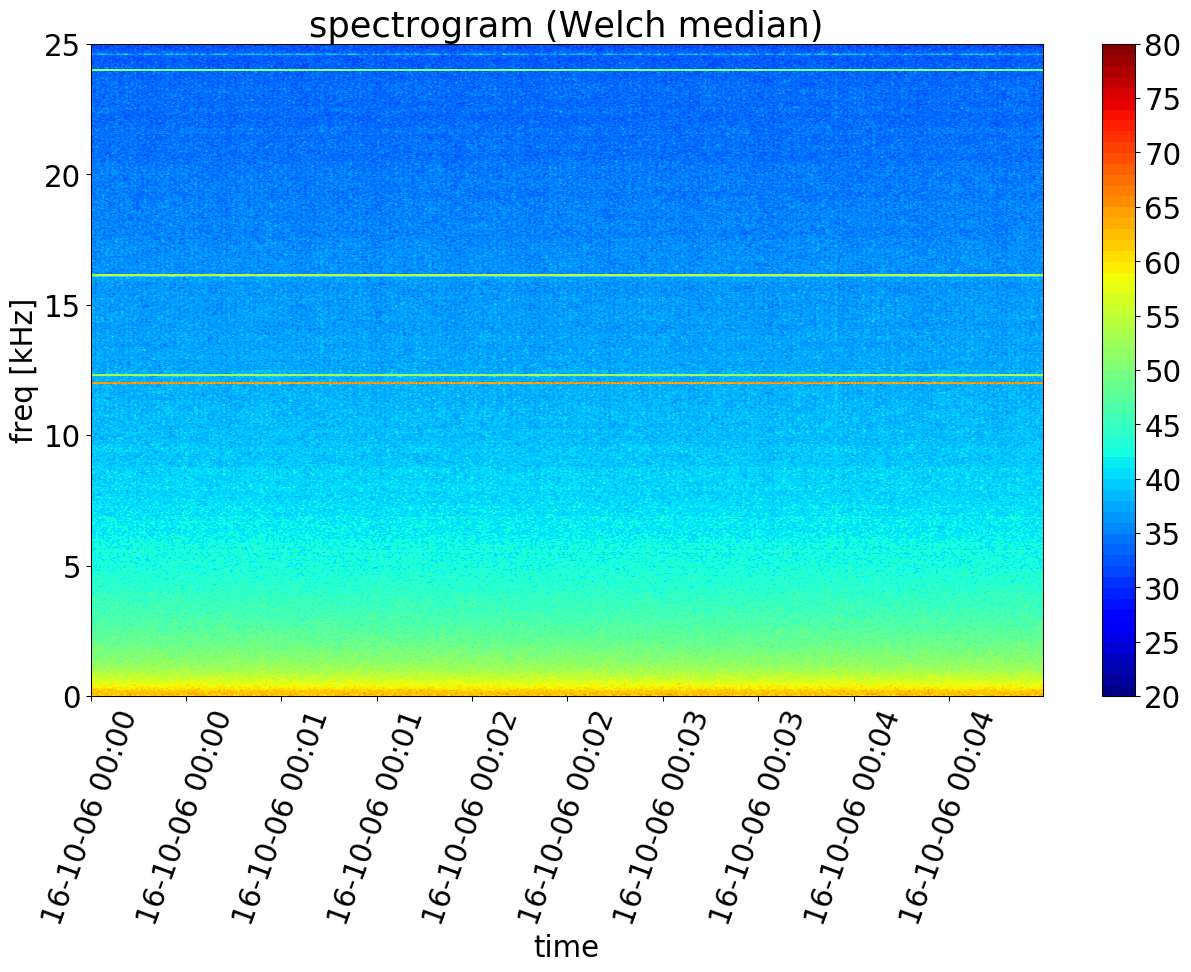

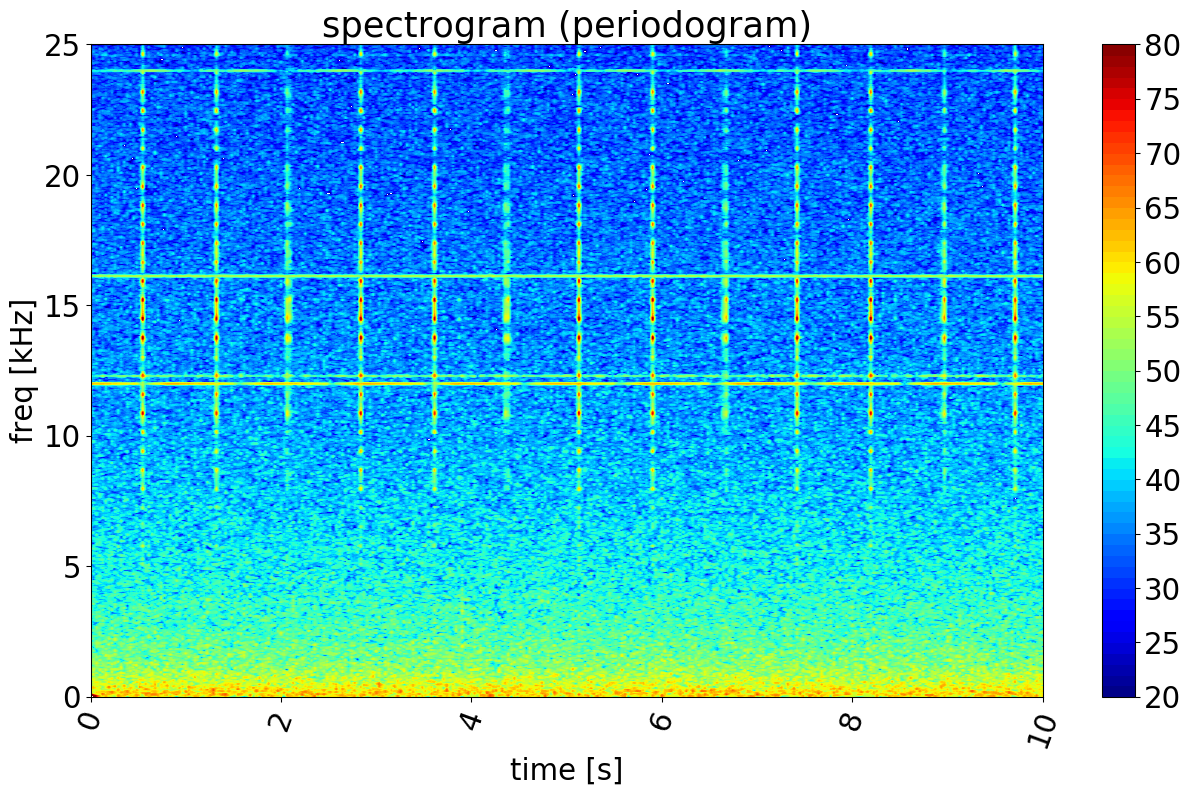

In [14]:
# compute and visualize spectrogram for noise data. No start and end time and node have to be defined
# as those are attributes of the OOIHydrophoneData object

# 1. Welch median over a data segment of 0.5s is used to compute the spectrum at each bin
# of the spectrogram
ooi1.compute_spectrogram(avg_time=0.5)
ooi1.spectrogram.freq = ooi1.spectrogram.freq / 1000
ooi1.spectrogram.visualize(title='spectrogram (Welch median)', ylabel='freq [kHz]',
                           fmin=0, fmax=25, vmin=20, vmax=80)

# 2. Periodogram estimate is used to compute the spectrum at each bin of the spectrogram
# To do so, the parameter avg_time is set to None (default). The amount of data are reduced to
# 10s to avoid memory overflow while plotting the data.
start_time2 = datetime.datetime(2016,10,6,0,0,0) # time of first sample
end_time2 = datetime.datetime(2016,10,6,0,0,10) # time of last sample
ooi2.get_acoustic_data(start_time2, end_time2, node='/PC01A')
ooi2.compute_spectrogram(L=2048)
ooi2.spectrogram.freq = ooi2.spectrogram.freq / 1000
ooi2.spectrogram.time = np.linspace(0, 10, len(ooi2.spectrogram.time))
ooi2.spectrogram.visualize(title='spectrogram (periodogram)', ylabel='freq [kHz]',
               xlabel='time [s]', fmin=0, fmax=25, vmin=20, vmax=80)

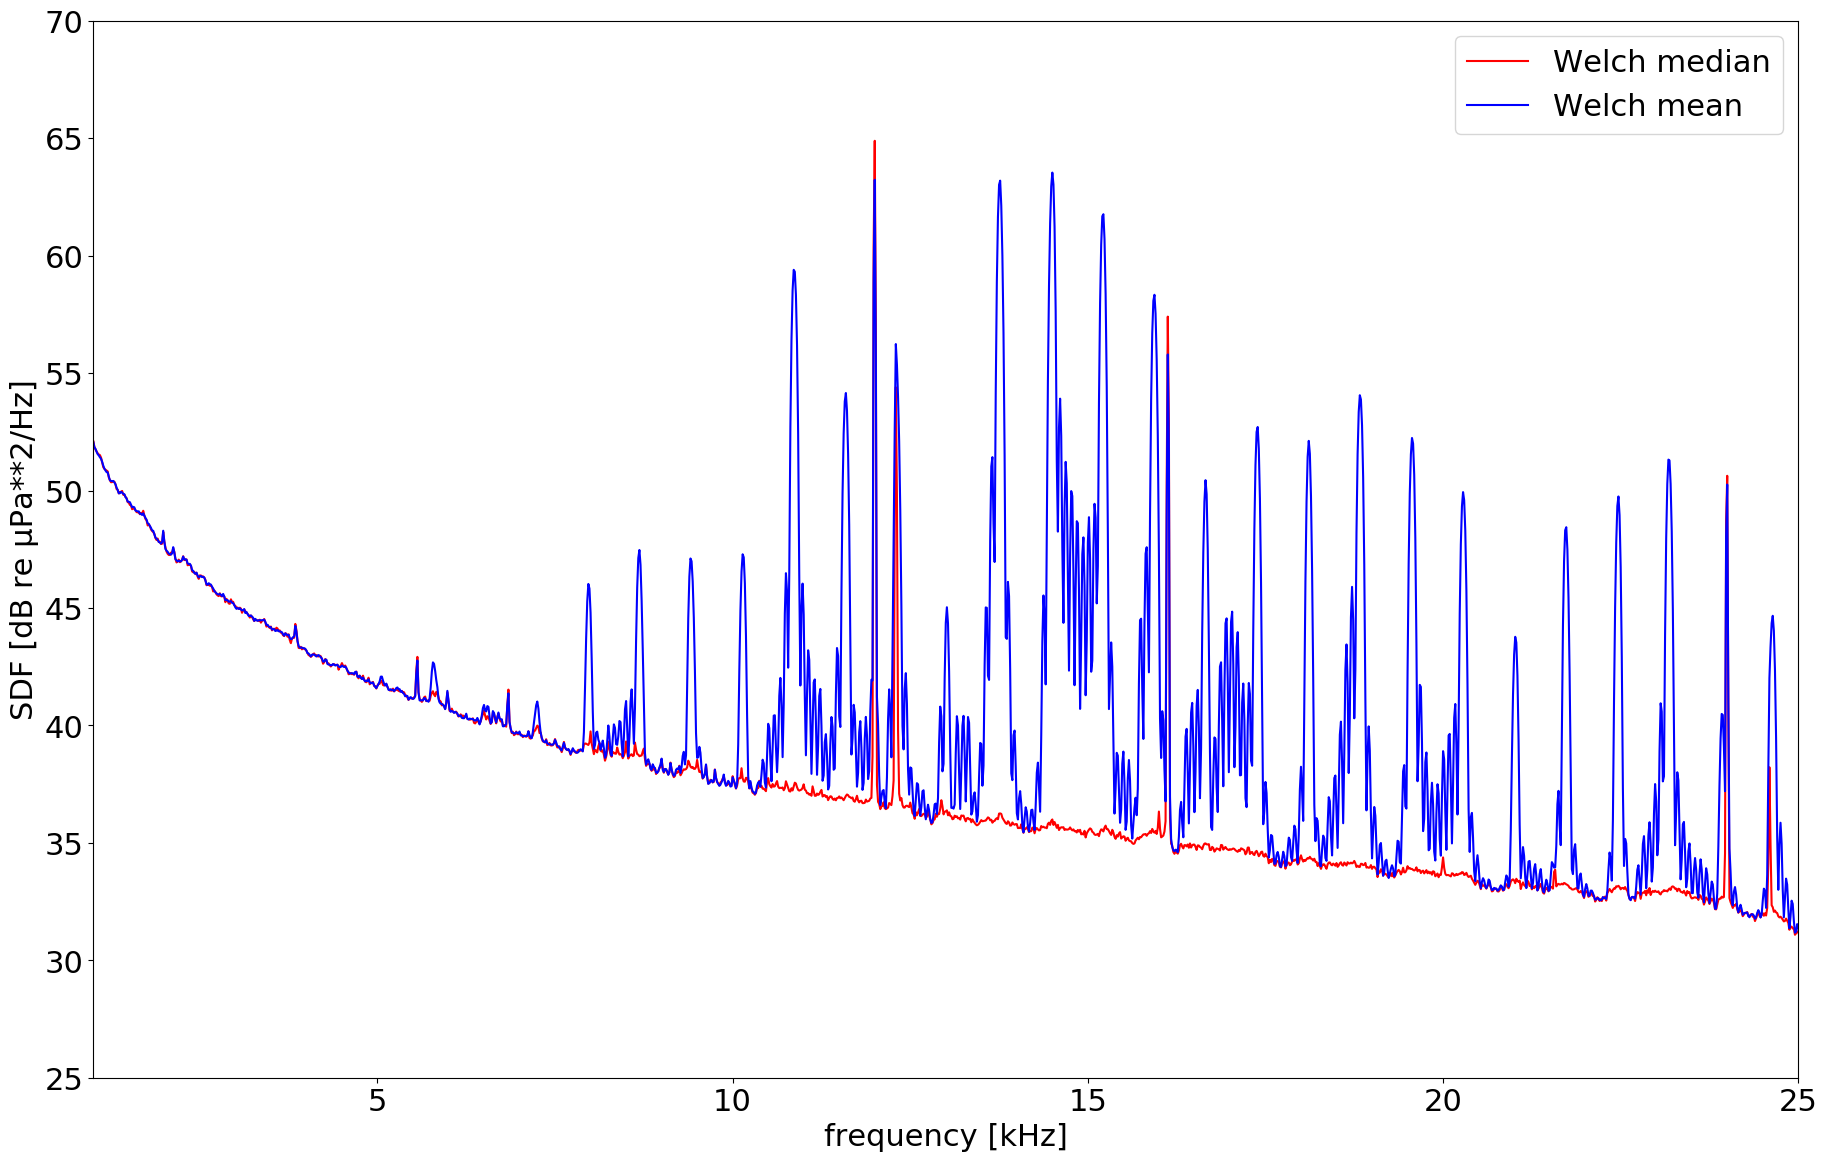

In [15]:
# power spectral density estimate of noise data using Welch's method
fig, ax = plt.subplots(figsize=(22,14), dpi=100)

# 1. using median averaging (default)
ooi1.compute_psd_welch()

f = ooi1.psd.freq / 1000
plt.plot(f, ooi1.psd.values, label='Welch median',color='r')

# 2. using mean averaging
ooi1.compute_psd_welch(avg_method='mean')

plt.plot(f, ooi1.psd.values, label='Welch mean',color='b')
plt.xlabel('frequency [kHz]')
plt.ylabel('SDF [dB re µPa**2/Hz]')
plt.xlim(1,25)
plt.ylim(25,70)
plt.legend()

In [ ]:
# Spectrogram and PSD using multiprocessing.

# spectrogram
ooi3.compute_spectrogram_mp(avg_time=1)
ooi3.spectrogram.visualize(title='spectrogram (Welch median)', fmin=0, fmax=25000, vmin=20, vmax=80)

# PSD
# Here, each segment has a length of 300s. For each segment a separate PSD estimate is 
# returned.
ooi3.compute_psd_welch_mp(300)

fig, ax = plt.subplots(figsize=(22,14), dpi=100)
f = ooi3.psd_list[0].freq / 1000
for psd in ooi3.psd_list:
    plt.plot(f, psd.values)
    
plt.xlabel('frequency [kHz]')
plt.ylabel('SDF [dB re µPa**2/Hz]')
plt.title('PSD (Welch median)')
plt.xlim(1,25)
plt.ylim(25,70)
plt.show()

In [ ]:
# test interpolation option in PSD estimates
ooi1.compute_psd_welch().psd.values
psd, f = ooi1.psd.values, ooi1.psd.freq / 1000

ooi1.compute_psd_welch(interpolate=1.0)
psd_interpolated, f_interpolated = ooi1.psd.values, ooi1.psd.freq / 1000


fig, ax = plt.subplots(figsize=(22,14), dpi=100)
plt.plot(f_interpolated, psd_interpolated, label='interpolated',color='b')
plt.plot(f, psd, label='original',color='r')
plt.xlabel('frequency [kHz]')
plt.ylabel('SDF [dB re µPa**2/Hz]')
plt.xlim(1,25)
plt.ylim(25,70)
plt.legend()

In [ ]:
# test lin/log scale option in PSD estimate
ooi1.compute_psd_welch(scale='log').psd.values
psd_log = ooi1.psd.values

ooi1.compute_psd_welch(scale='lin')
psd_lin, f = ooi1.psd.values, ooi1.psd.freq / 1000


fig, ax = plt.subplots(figsize=(22,14), dpi=100)
plt.plot(f, 10*np.log10(psd_lin), label='lin', color='b')
plt.plot(f, psd_log, label='log', color='r')
plt.xlabel('frequency [kHz]')
plt.ylabel('SDF [dB re µPa**2/Hz]')
plt.xlim(1,25)
plt.ylim(25,70)
plt.legend()